In [1]:
import glob
import math
import string
import corner
import pickle
import numpyro
import scipy.stats
import numpy as np
import arviz as az
from jax import vmap
import jax.numpy as jnp
import jax.random as random
import hmc_fmiso_project as fp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from jax.experimental.ode import odeint
from numpyro.infer import log_likelihood

show_f = False

# Define the location pattern for the data files, specifying where to look for tumor volume files
files_location = './Data/*_grp_*'

# Call the read_data function with verbose output enabled, to read data and print process details
full_data = fp.read_data(files_location,verbose = True,number_of_data = 9,filter = True, biomarkers = True)
#full_data = fp.read_data(files_location,verbose = False)

# Plot data from the provided full_data
# Set the number of columns in the subplot grid to 4
# Set show to False to suppress displaying the plots
file_location = './Output/'

fp.plot_data(full_data, nCols = 2, save = False, show = False,figure_name = f'{file_location}all_data')

Scenario: 15120-TG7, Untreated, 4423, 4435, 4437, 4440, 4447, 4468, Pac+Carbo-4wk, 4430, 4431, biomarkers, 4430, 4431
Scenario: 2277-R1TG9, Untreated, 4809, 4813, 4815, 4822, 4826, 4839, Pac+Carbo-4wk, 4811, 4814, 4834, biomarkers, 4811, 4814, 4834
Scenario: 3204-R3TG5, Untreated, 4691, 4702, 4714, Pac+Carbo-4wk, 4678, 4686, 4705, biomarkers, 4678, 4686, 4705
Scenario: 4849-R1TG15, Untreated, 4301, 4315, 4332, 4362, 4364, 4373, Pac+Carbo-4wk, 4304, 4331, 4354, biomarkers, 4304, 4331, 4354
Scenario: BCM-3204, Untreated, 11, 15, 8, Pac+Carbo-4wk, 13, 28, biomarkers, 13, 28
Scenario: BMC-4175, Untreated, 6702, 6704, 6712, Pac+Carbo-4wk, 6720, 6723, biomarkers, 6720, 6723
Scenario: BRA45-R2TG8-Repeat, Untreated, 4504, 4506, 4507, 4515, Pac+Carbo-4wk, 4541, biomarkers, 4541
Scenario: HCI-034-TG11-Repeat, Untreated, 4215, 4224, 4229, 4233, 4235, 4240, Pac+Carbo-4wk, 4203, 4212, 4239, biomarkers, 4203, 4212, 4239
Scenario: MDA-BCM-IBC-103, Untreated, 6809, 6829, 6835, Pac+Carbo-4wk, 6814, 681

In [2]:
# Define the Bayesian model using NumPyro
def tumor_model_jax(full_data, model_extension, group, treat):

    model_name = 'model' + model_extension
    model_func = getattr(fp, model_name)

    if '_exp' == model_extension:
        r = numpyro.sample('r', dist.Uniform(0, 1))  # Growth rate parameter
    elif '_mendel' == model_extension:
        r = numpyro.sample('r', dist.Uniform(0, 1))  # Growth rate parameter
        b = numpyro.sample('b', dist.Uniform(0, 3))
    elif '_bert' == model_extension:
        r = numpyro.sample('r', dist.Uniform(0, 2))  # Growth rate parameter
        b = numpyro.sample('b', dist.Uniform(0, 1))
    elif '_lin' == model_extension:
        r = numpyro.sample('r', dist.Uniform(0, 800))
        b = numpyro.sample('b', dist.Uniform(0, 800))
    elif '_gomp' == model_extension:
        r = numpyro.sample('r', dist.Uniform(0, 1))
        b = numpyro.sample('b', dist.Uniform(0, 8000))
        c = numpyro.sample('c', dist.Uniform(0, 800))
    elif '_surf' == model_extension:
        r = numpyro.sample('r', dist.Uniform(0, 800))
        b = numpyro.sample('b', dist.Uniform(0, 800))
    elif '_log' == model_extension:
        r = numpyro.sample('r', dist.Uniform(0, 1))
        cc = numpyro.sample('cc', dist.Uniform(1, 20000))
    elif '_exp_treat' == model_extension:
        a_treat = numpyro.sample('a_treat', dist.Uniform(0, 1.0))
        b_treat = numpyro.sample('b_treat', dist.Uniform(0, 1.0))
        input_name = f'_exp_{group}_Untreated'
        # Load the .npz file
        bestfile = np.load(f'{file_location}multiple_ll_pars{input_name}.npz')
        # Access the variables
        best_pars = bestfile['best_pars']
        labels = bestfile['labels']
        r = best_pars['r' == labels]
        if '1wk' in treat:
            tau_treat = jnp.array([0])
        elif '4wk' in treat:
            tau_treat = jnp.array([0, 7, 14, 21])
    elif '_exp_bio' == model_extension:
        a_treat = numpyro.sample('a_treat', dist.Uniform(0, 1.0))
        b_treat = numpyro.sample('b_treat', dist.Uniform(0, 1.0))
        pADC_tt = numpyro.sample('pADC_tt', dist.Uniform(0, 1.4))
        pKtr_tt = numpyro.sample('pKtr_tt', dist.Uniform(0, 2.0))
        input_name = f'_exp_{group}_Untreated'
        # Load the .npz file
        bestfile = np.load(f'{file_location}multiple_ll_pars{input_name}.npz')
        # Access the variables
        best_pars = bestfile['best_pars']
        labels = bestfile['labels']
        r = best_pars['r' == labels]
        if '1wk' in treat:
            tau_treat = jnp.array([0])
        elif '4wk' in treat:
            tau_treat = jnp.array([0, 7, 14, 21])
    elif '_exp_sas' == model_extension:
        a_treat = numpyro.sample('a_treat', dist.Uniform(0, 1.0))
        b_treat = numpyro.sample('b_treat', dist.Uniform(0, 1.0))
        pADC_tt = numpyro.sample('pADC_tt', dist.Uniform(0, 1.4))
        pKtr_tt = jnp.array(0.0, dtype=jnp.float32)
        input_name = f'_exp_{group}_Untreated'
        # Load the .npz file
        bestfile = np.load(f'{file_location}multiple_ll_pars{input_name}.npz')
        # Access the variables
        best_pars = bestfile['best_pars']
        labels = bestfile['labels']
        r = best_pars['r' == labels]
        if '1wk' in treat:
            tau_treat = jnp.array([0])
        elif '4wk' in treat:
            tau_treat = jnp.array([0, 7, 14, 21])
    elif '_exp_sio' == model_extension:
        a_treat = numpyro.sample('a_treat', dist.Uniform(0, 1.0))
        b_treat = numpyro.sample('b_treat', dist.Uniform(0, 1.0))
        pADC_tt = jnp.array(1.0, dtype=jnp.float32)
        pKtr_tt = jnp.array(1.0, dtype=jnp.float32)
        input_name = f'_exp_{group}_Untreated'
        # Load the .npz file
        bestfile = np.load(f'{file_location}multiple_ll_pars{input_name}.npz')
        # Access the variables
        best_pars = bestfile['best_pars']
        labels = bestfile['labels']
        r = best_pars['r' == labels]
        if '1wk' in treat:
            tau_treat = jnp.array([0])
        elif '4wk' in treat:
            tau_treat = jnp.array([0, 7, 14, 21])
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.1, 500.0))  # Noise std deviation

    y_model = []
    for m in full_data[group][treat]:
        t = full_data[group][treat][m][:,0]
        y = full_data[group][treat][m][:,1]
        if '4wk' in treat and ('_exp_bio' == model_extension or '_exp_sio' == model_extension or '_exp_sas' == model_extension):
            ADC = full_data[group]['biomarkers'][m]['ADC']
            Ktrans = full_data[group]['biomarkers'][m]['Ktrans']
        ic = numpyro.sample('ic_' + group + '_' + m, dist.Uniform(0, 800.0))  # Initial condition

        if '_exp' == model_extension:
            s_model = odeint(model_func, ic, t, r)
        elif '_mendel' == model_extension or '_bert' == model_extension or '_lin' == model_extension or '_surf' == model_extension:
            s_model = odeint(model_func, ic, t, r, b)
        elif '_log' == model_extension:
            s_model = odeint(model_func, ic, t, r, cc)
        elif '_gomp' == model_extension:
            s_model = odeint(model_func, ic, t, r, b, c)
        elif '_exp_treat' == model_extension:
            s_model = odeint(model_func, ic, t, r, a_treat, b_treat, tau_treat.astype(jnp.float32))
        elif '_exp_bio' == model_extension:
            s_model = odeint(model_func, ic, t, r, a_treat, b_treat, tau_treat.astype(jnp.float32), pADC_tt, pKtr_tt, ADC, Ktrans)
        elif '_exp_sas' == model_extension:
            s_model = odeint(model_func, ic, t, r, a_treat, b_treat, tau_treat.astype(jnp.float32), pADC_tt, pKtr_tt, ADC, Ktrans)
        elif '_exp_sio' == model_extension:
            s_model = odeint(model_func, ic, t, r, a_treat, b_treat, tau_treat.astype(jnp.float32), pADC_tt, pKtr_tt, ADC, Ktrans)
        
        y_model.append(s_model)
        numpyro.sample(f'obs_{m}', dist.Normal(s_model, sigma), obs=y)
        
    # Observation model
    numpyro.deterministic(f'y_model_{group}_{treat}', y_model)

In [3]:
calibrate = False
if calibrate:
    # Run MCMC with NUTS
    #all_models = ['_bert','_exp','_gomp','_lin','_log','_mendel','_surf']
    all_models = ['_exp_sas']
    for model_extension in all_models:
        #all_treat = ['Untreated', 'Pac+Carbo']
        all_treat = ['Pac+Carbo-4wk']
        for treat in all_treat:
            for group in full_data:
                rng_key = random.PRNGKey(0)
                
                kernel = NUTS(tumor_model_jax, target_accept_prob=0.9)
                mcmc = MCMC(kernel, num_warmup=3000, num_samples=6000, num_chains=1)
                mcmc.run(rng_key, full_data = full_data, model_extension = model_extension, group = group, treat = treat)
                mcmc.print_summary()
        
                # Save the MCMC object
                output_name = f'{model_extension}_{group}_{treat}'
                with open(f'{file_location}mcmc{output_name}.pkl', 'wb') as f:
                    pickle.dump(mcmc, f)
                
                samples = mcmc.get_samples()
                predictive_samples = samples[f'y_model_{group}_{treat}']
                samples.pop(f'y_model_{group}_{treat}',None)
                
                # Save `my_samples` and `predictive_samples` to a file
                with open(f'{file_location}chain{output_name}.pkl', "wb") as f:
                    pickle.dump(samples, f)
                
                with open(f'{file_location}prediction{output_name}.pkl', "wb") as f:
                    pickle.dump(predictive_samples, f)
            
                labels = [l for l in samples.keys()]
                min_index, best_pars, max_ll = fp.get_best_pars_maxll(predictive_samples, full_data, group, treat, samples)
        
                k = len(labels)-np.sum(['ic' in x for x in labels])
                n = 0
                for mouse in full_data[group][treat]:
                    n += len(full_data[group][treat][mouse][:,0])
                bic_results = k*np.log(n)-2*max_ll
        
                # Compute log-likelihood for each data point
                ll = log_likelihood(tumor_model_jax, samples, full_data=full_data, model_extension=model_extension, group=group, treat=treat)
                
                # Ensure correct site name for observation
                obs_site_name = f'obs_{list(full_data[group][treat].keys())[0]}'  # First key should correspond to an observation
                if obs_site_name not in ll:
                    raise KeyError(f"Observation site '{obs_site_name}' not found in log-likelihood results. Available keys: {ll.keys()}")
                
                # Compute WAIC
                lppd = np.sum(np.log(np.mean(np.exp(ll[obs_site_name]), axis=0)))  # Log pointwise predictive density
                p_waic = np.sum(np.var(ll[obs_site_name], axis=0))  # Effective number of parameters
                waic = -2 * (lppd - p_waic)
        
                np.savez(f'{file_location}multiple_ll_pars{output_name}.npz', max_ll = max_ll, best_pars = best_pars, min_index = min_index, labels = labels, bic_results = bic_results, waic = waic, lppd = lppd, p_waic = p_waic)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Scenario: 15120-TG7, Untreated, 4423, 4435, 4437, 4440, 4447, 4468, Pac+Carbo-4wk, 4430, 4431, biomarkers, 4430, 4431
Scenario: 2277-R1TG9, Untreated, 4809, 4813, 4815, 4822, 4826, 4839, Pac+Carbo-4wk, 4811, 4814, 4834, biomarkers, 4811, 4814, 4834
Scenario: 3204-R3TG5, Untreated, 4691, 4702, 4714, Pac+Carbo-4wk, 4678, 4686, 4705, biomarkers, 4678, 4686, 4705
Scenario: 4849-R1TG15, Untreated, 4301, 4315, 4332, 4362, 4364, 4373, Pac+Carbo-4wk, 4304, 4331, 4354, biomarkers, 4304, 4331, 4354
Scenario: BCM-3204, Untreated, 11, 15, 8, Pac+Carbo-4wk, 13, 28, biomarkers, 13, 28
Scenario: BMC-4175, Untreated, 6702, 6704, 6712, Pac+Carbo-4wk, 6720, 6723, biomarkers, 6720, 6723
Scenario: BRA45-R2TG8-Repeat, Untreated, 4504, 4506, 4507, 4515, Pac+Carbo-4wk, 4541, biomarkers, 4541
Scenario: HCI-034-TG11-Repeat, Untreated, 4215, 4224, 4229, 4233, 4235, 4240, Pac+Carbo-4wk, 4203, 4212, 4239, biomarkers, 4203, 4212, 4239
Scenario: MDA-BCM-IBC-103, Untreated, 6809, 6829, 6835, Pac+Carbo-4wk, 6814, 681

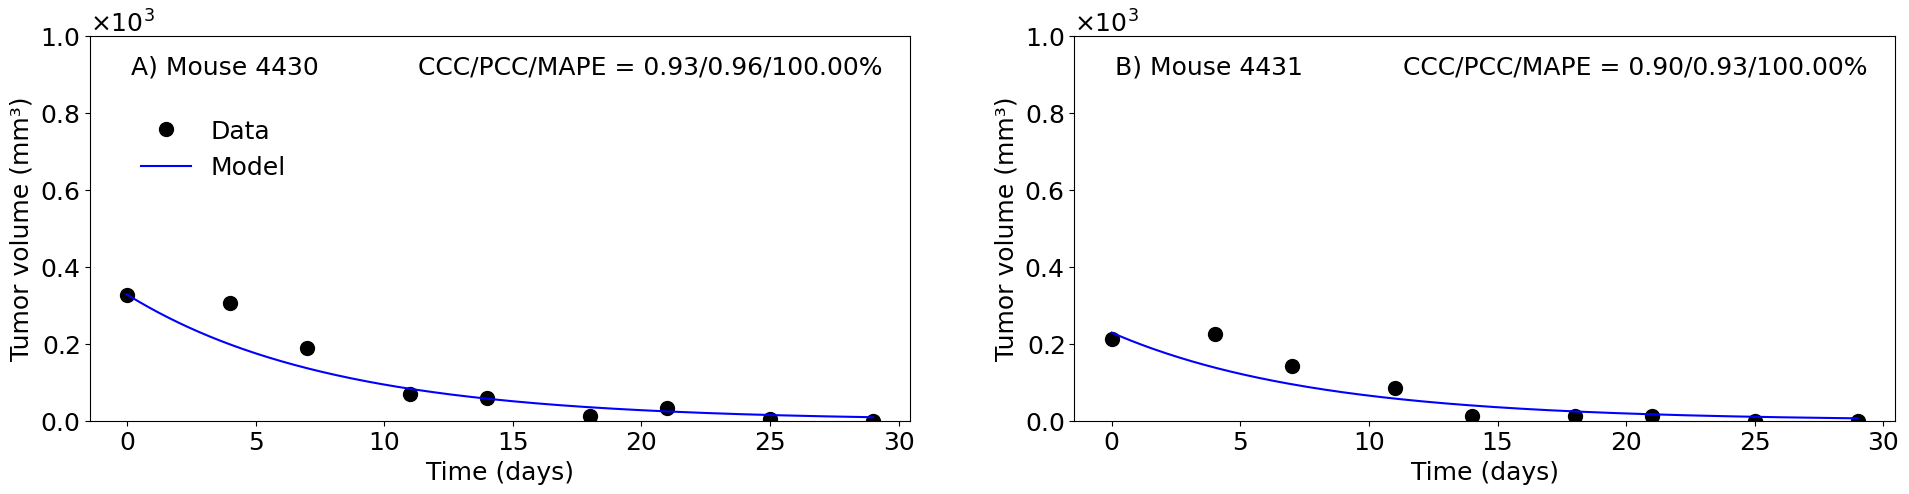

Actual values must not contain zeros
Actual values must not contain zeros


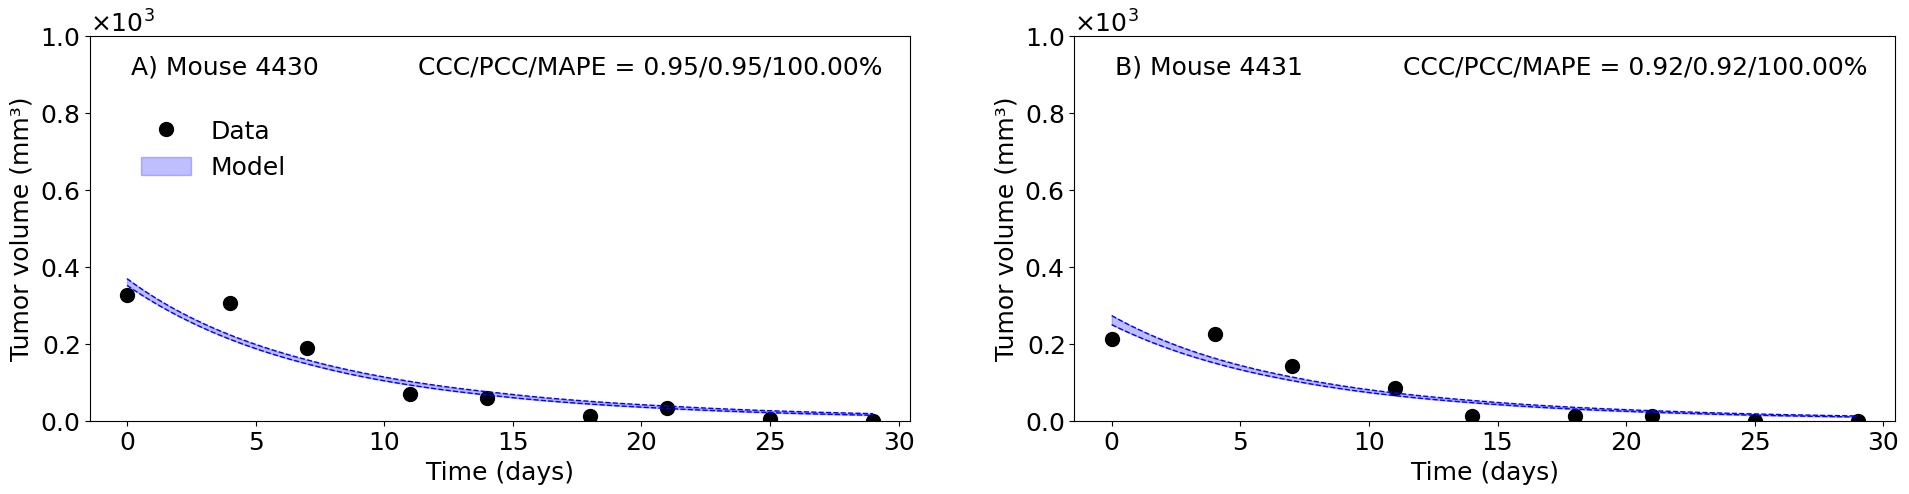

Actual values must not contain zeros


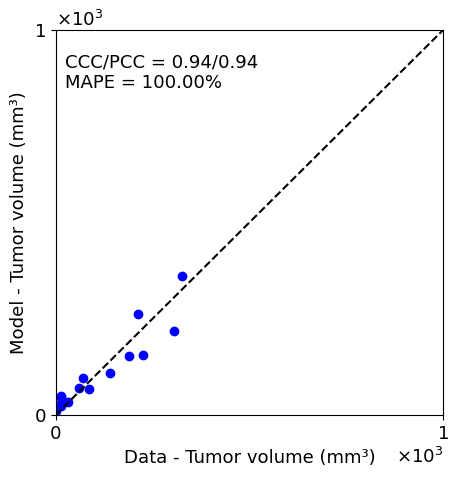

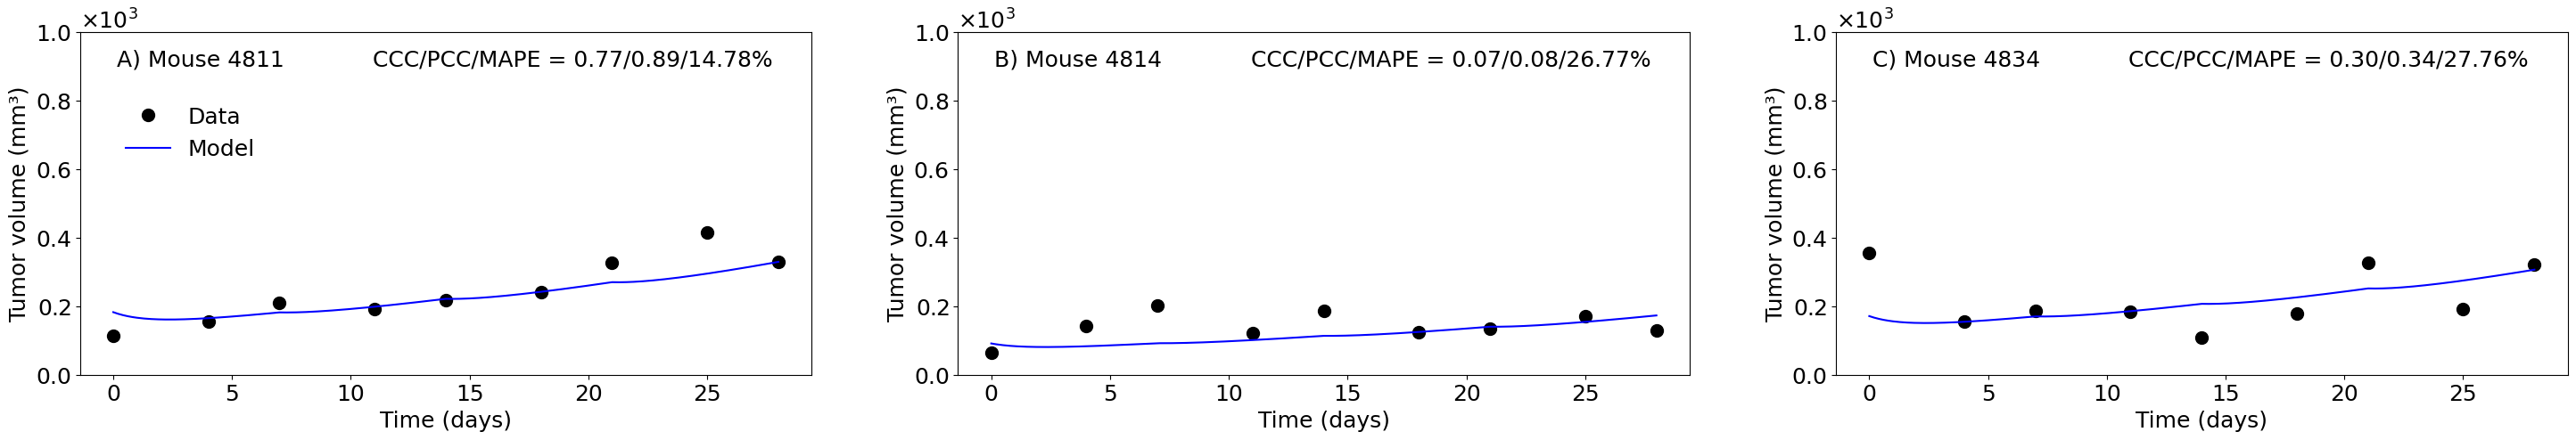

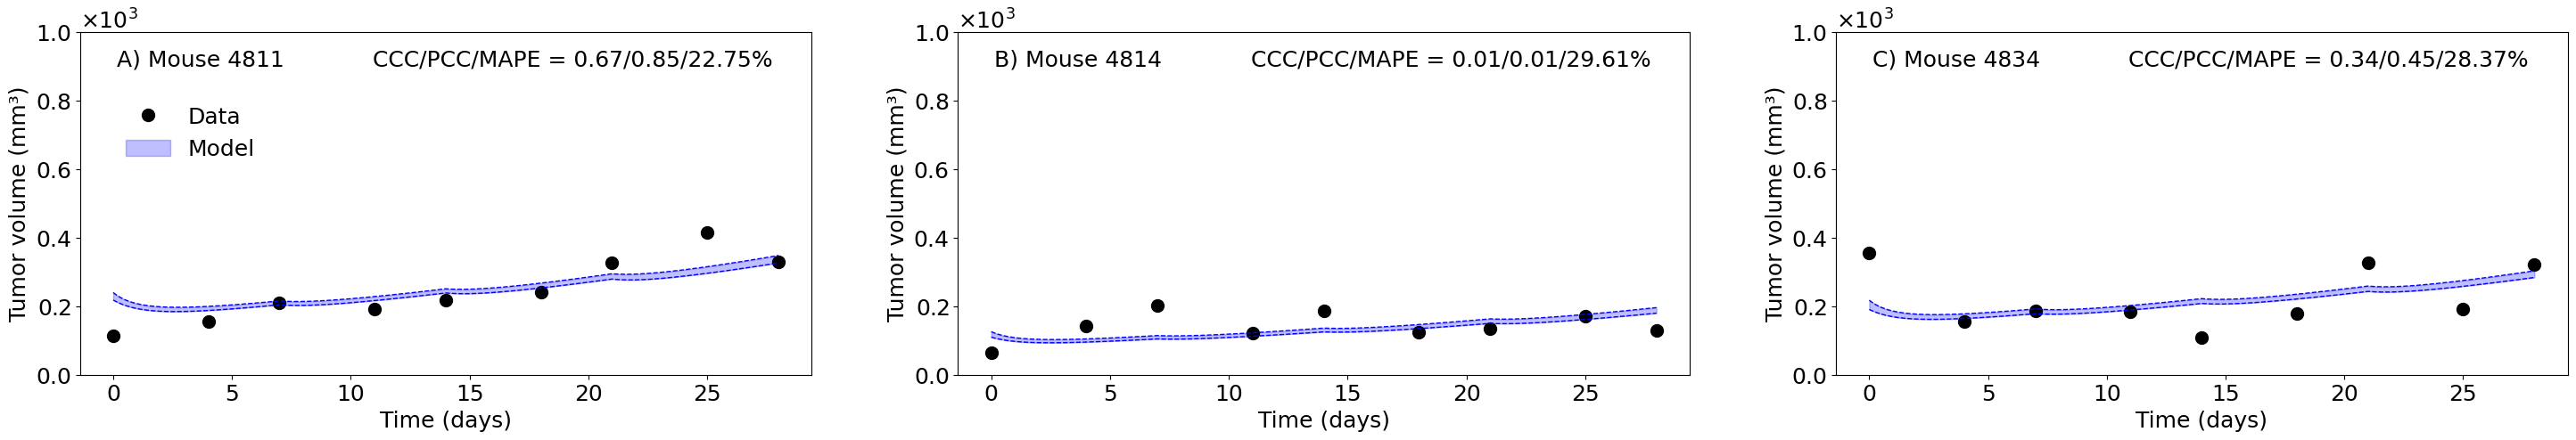

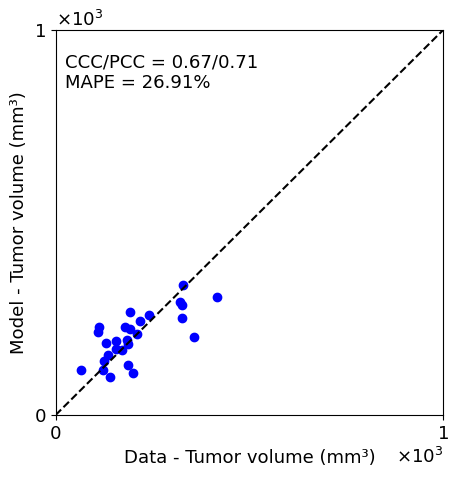

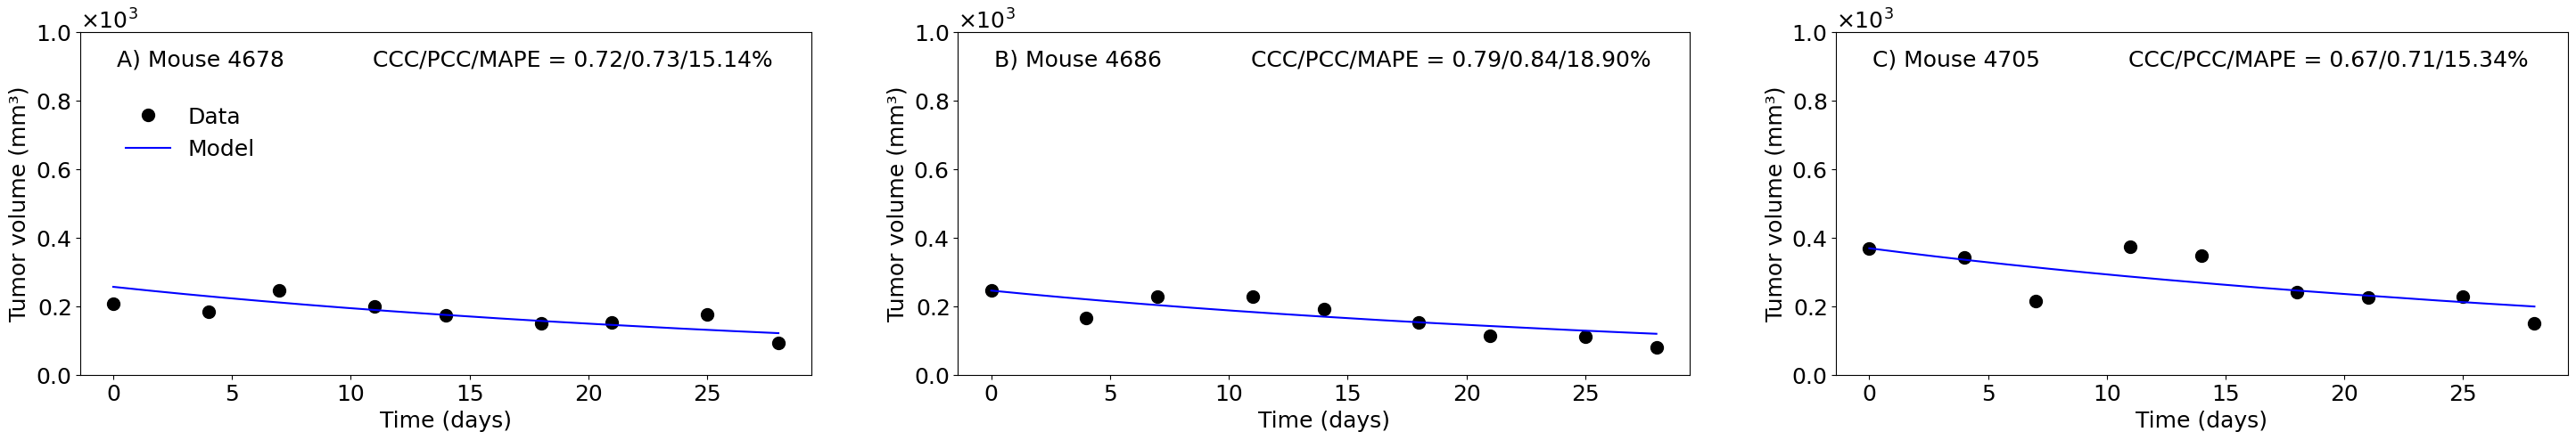

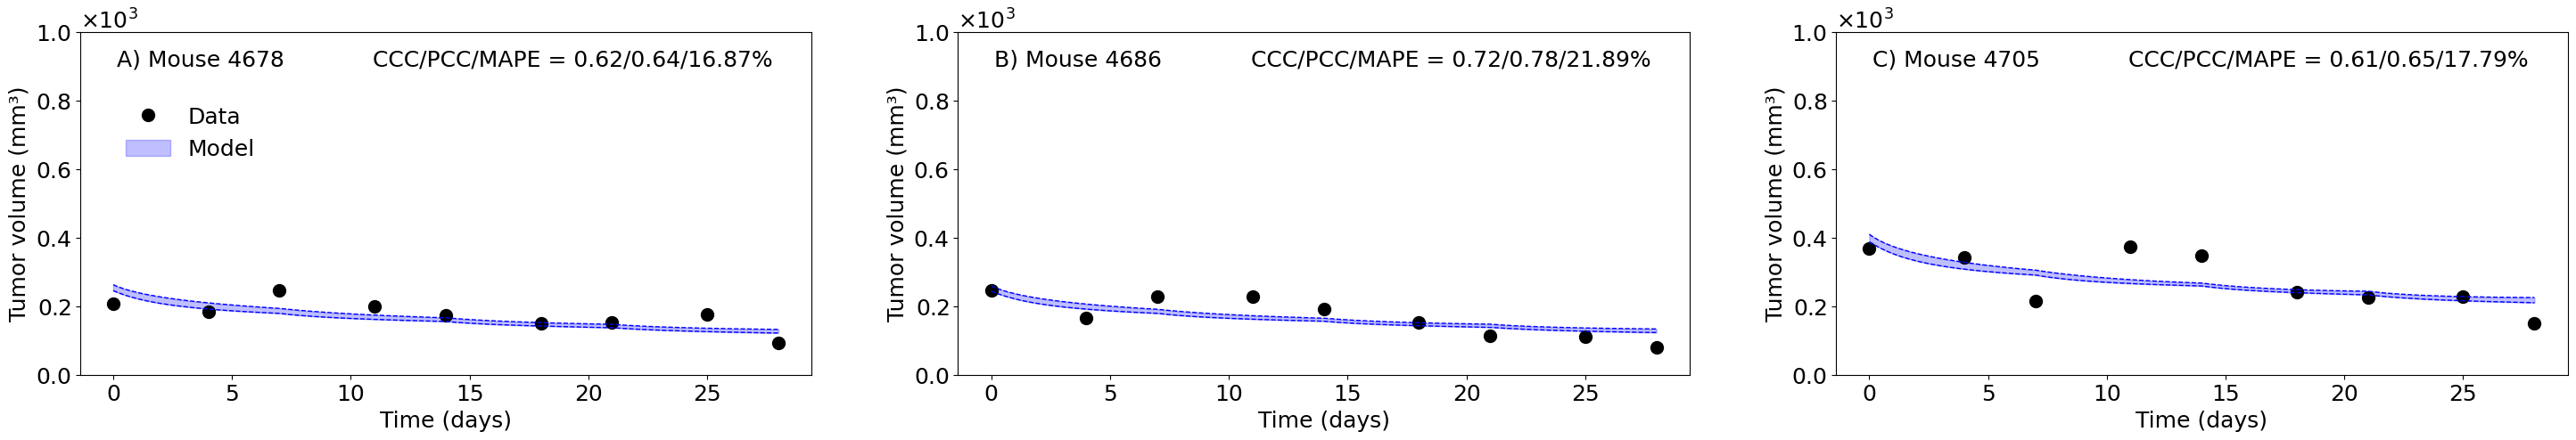

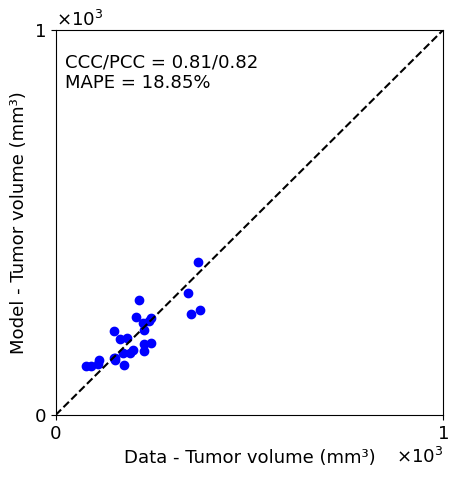

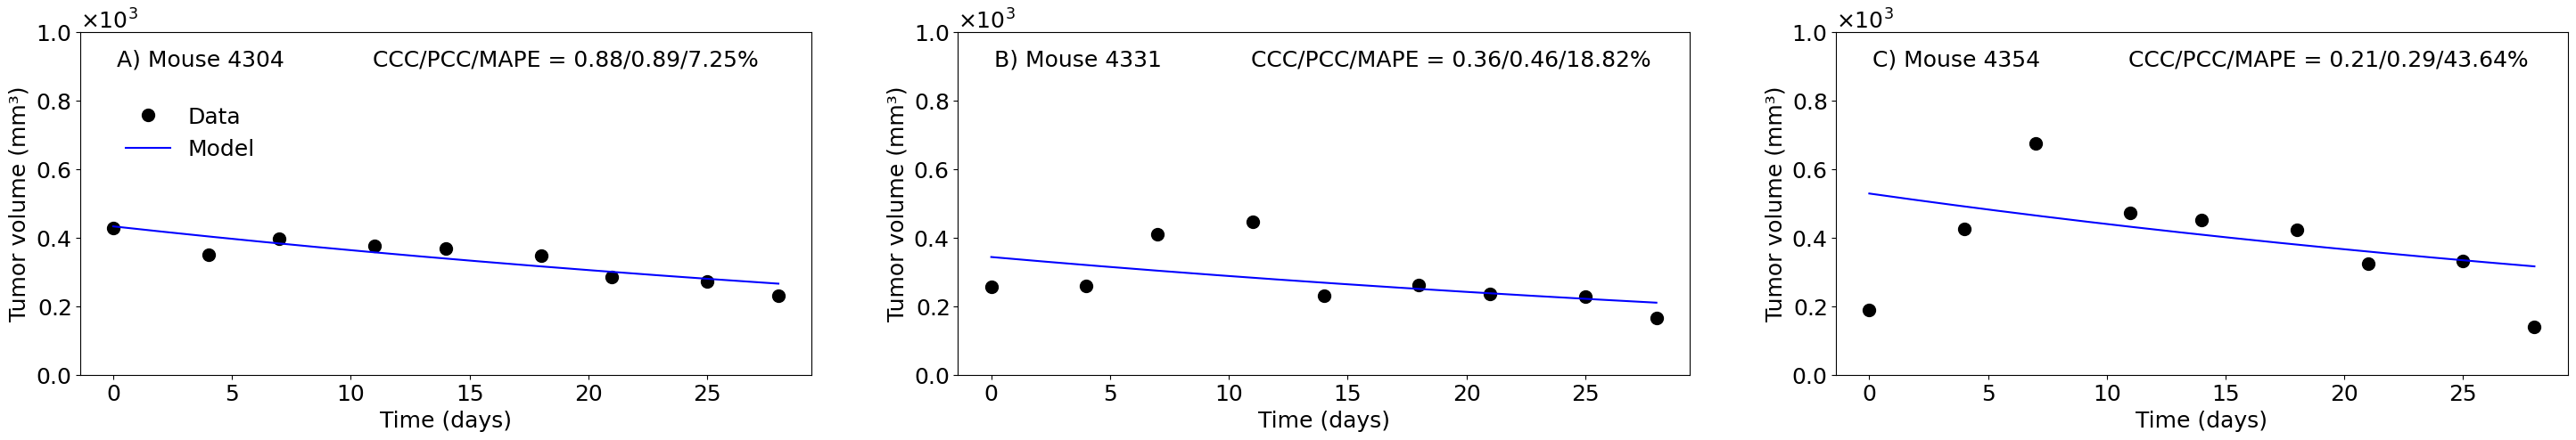

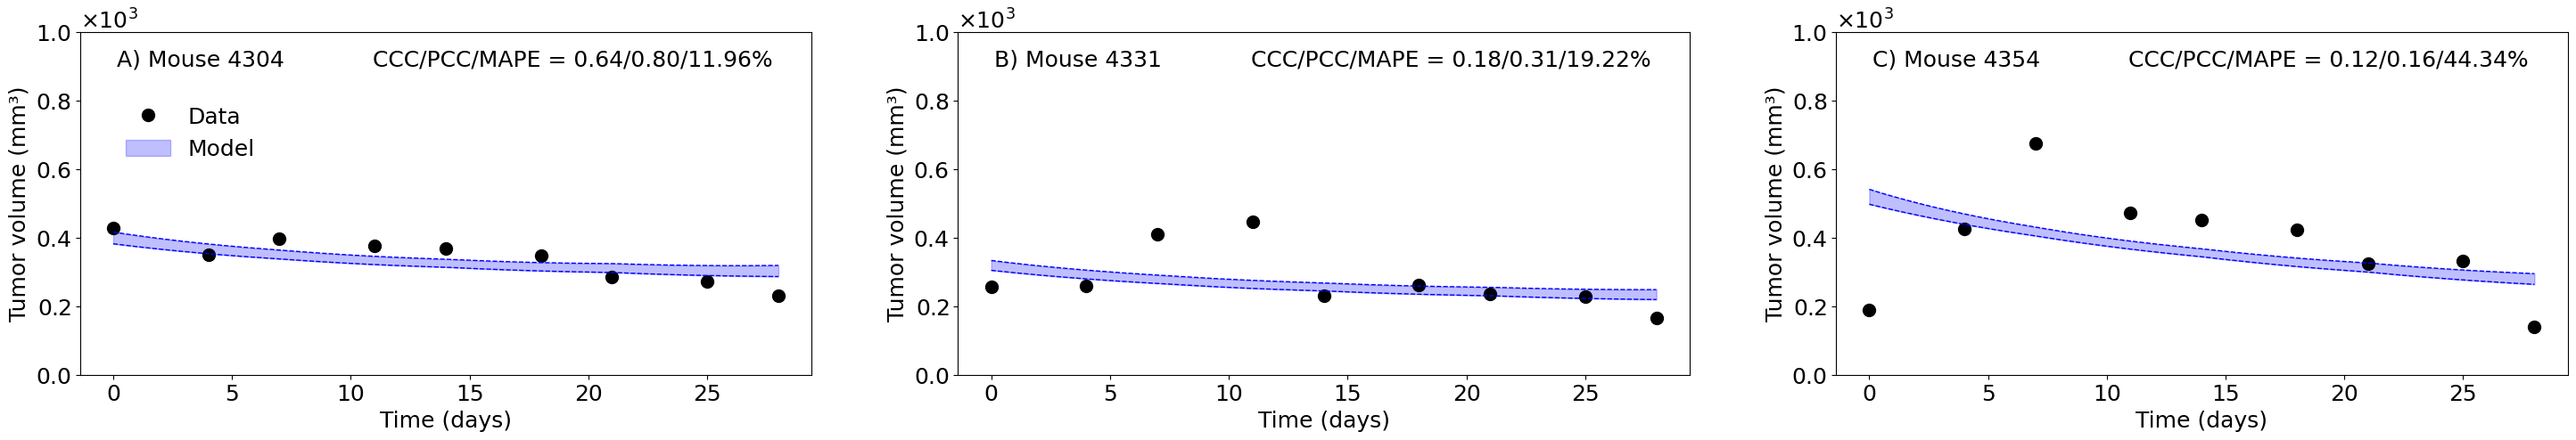

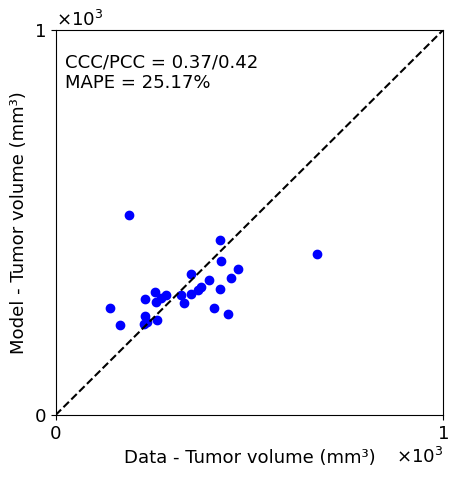

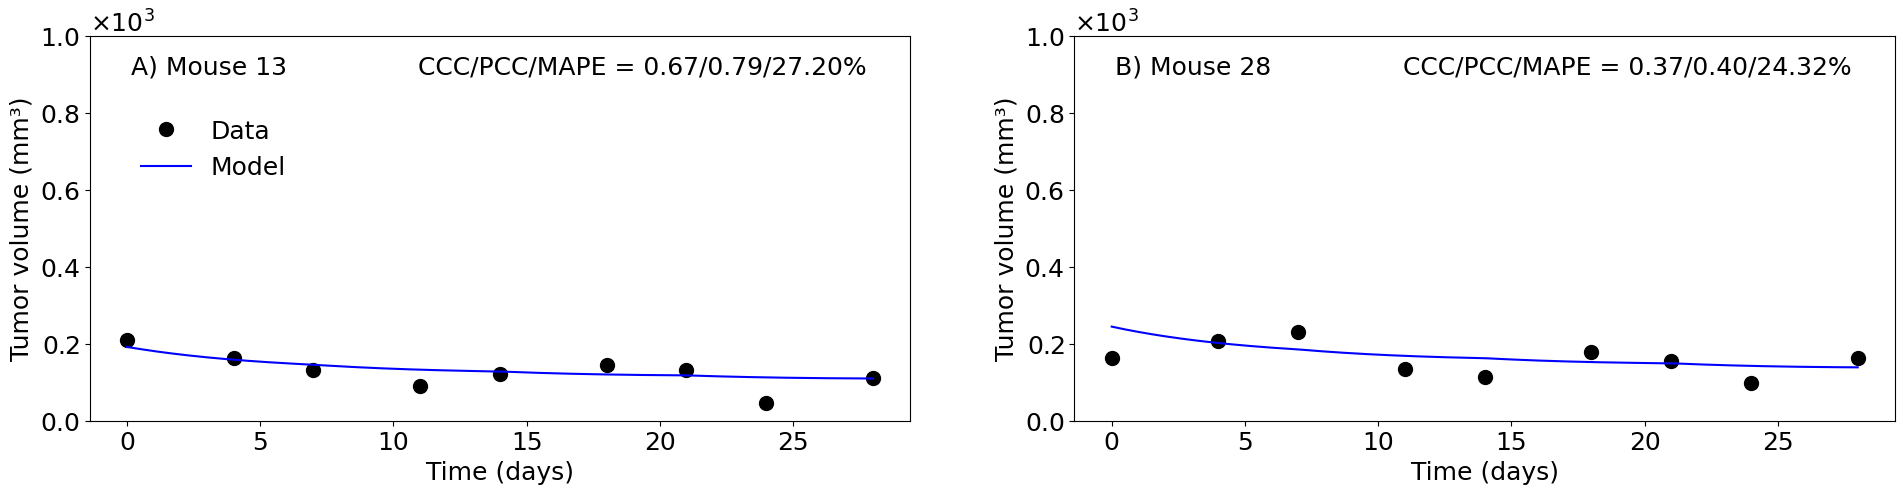

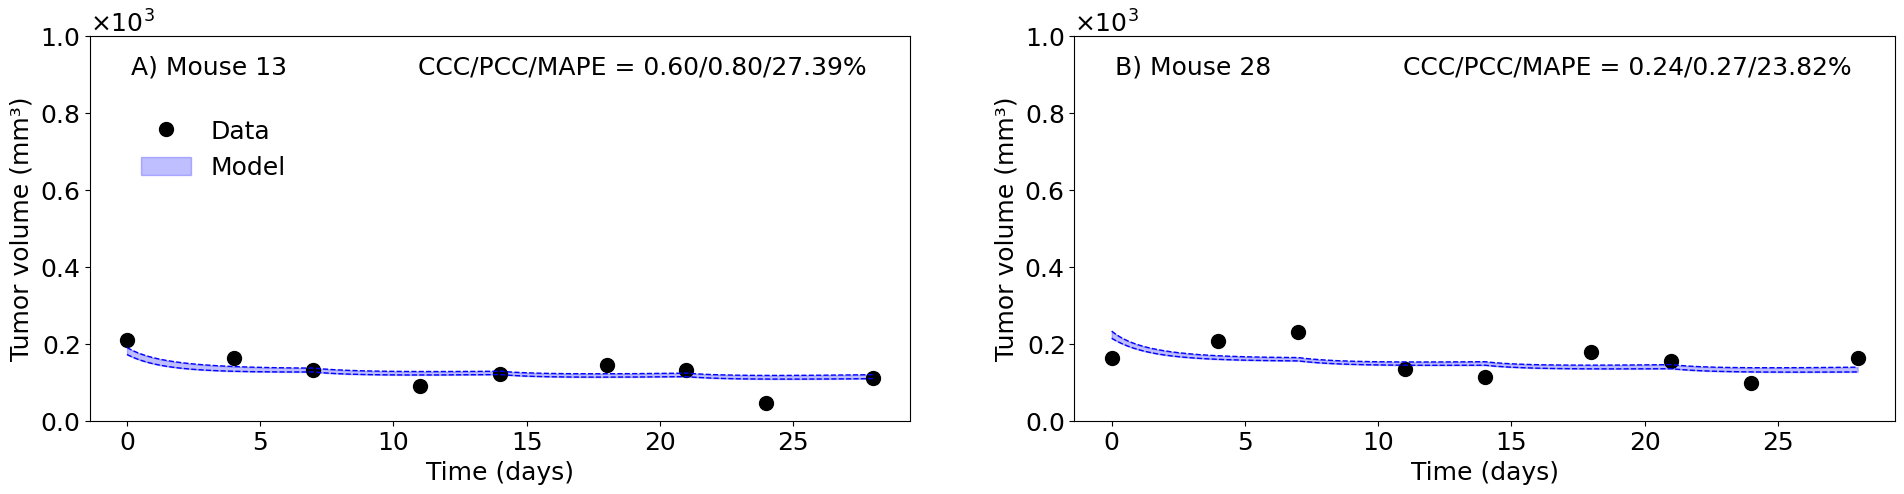

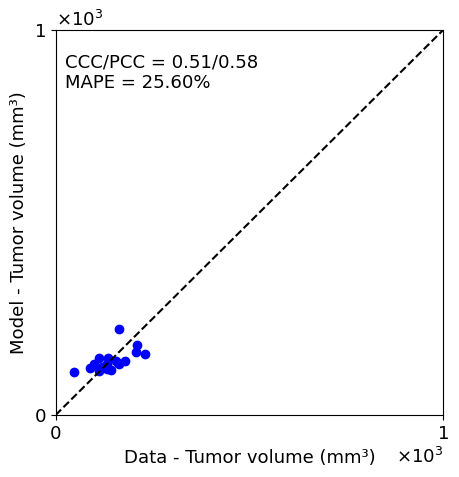

Actual values must not contain zeros
Actual values must not contain zeros


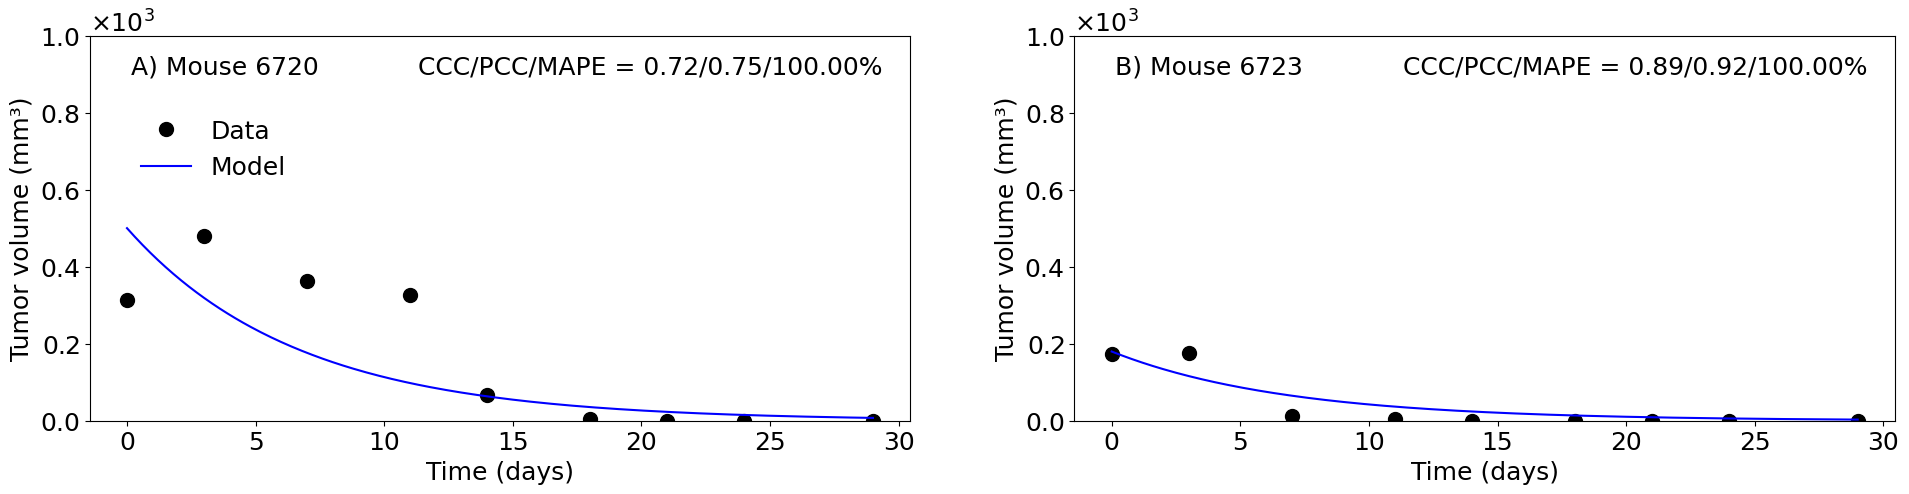

Actual values must not contain zeros
Actual values must not contain zeros


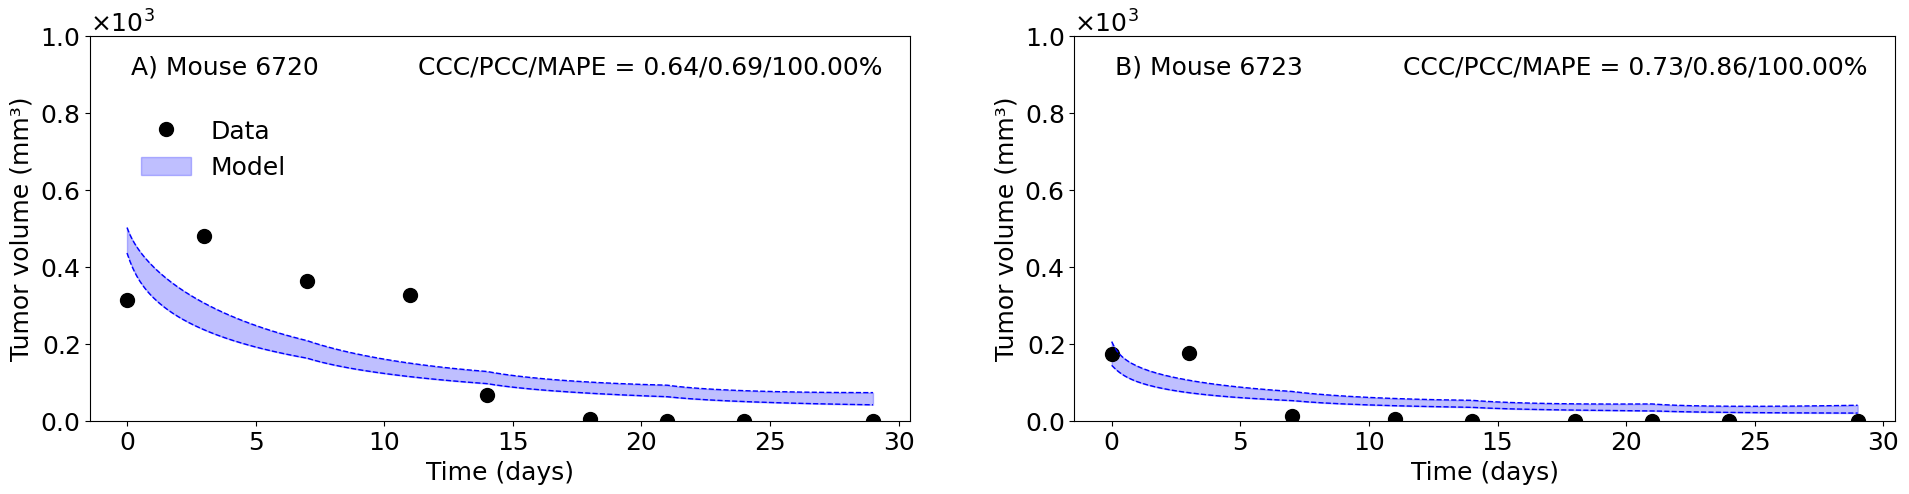

Actual values must not contain zeros


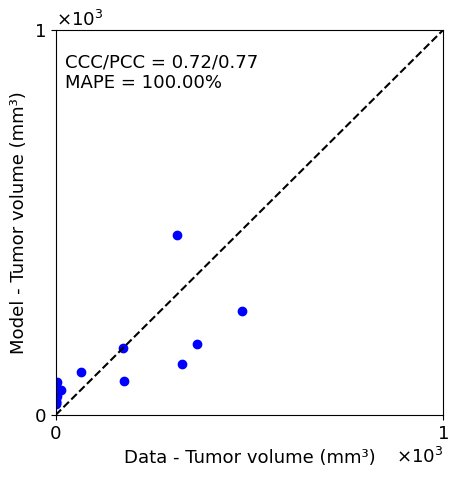

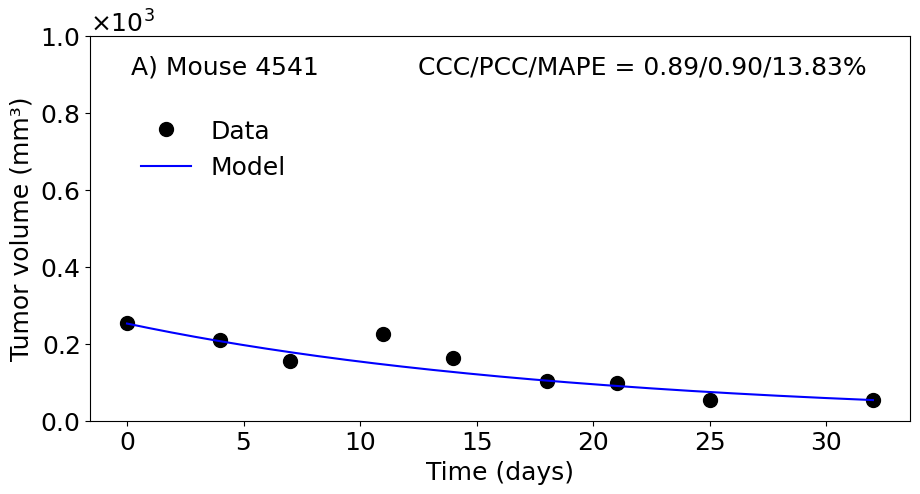

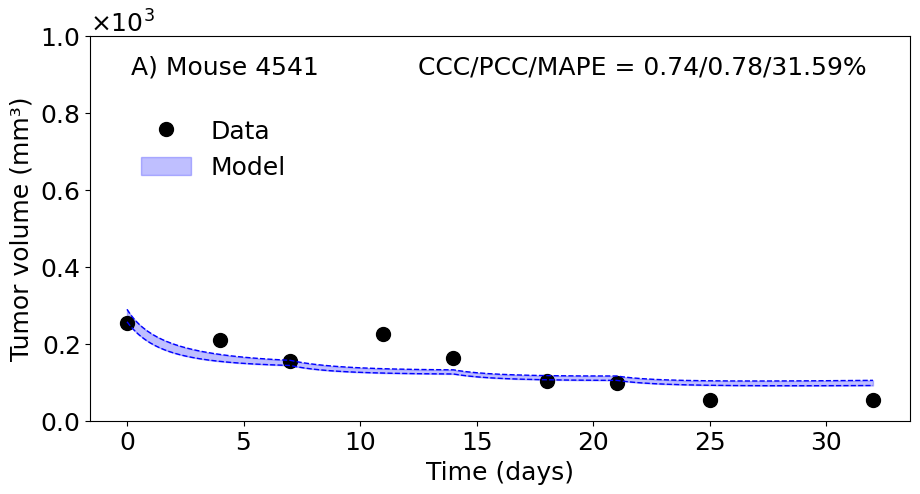

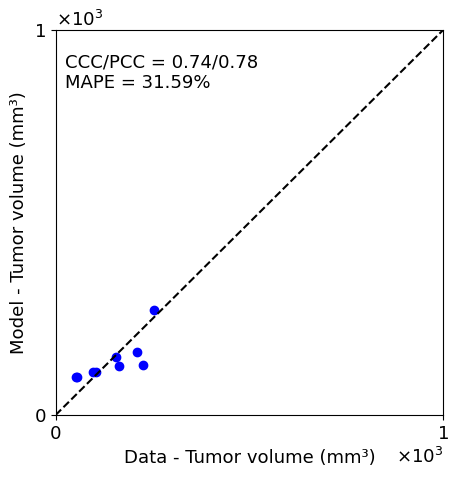

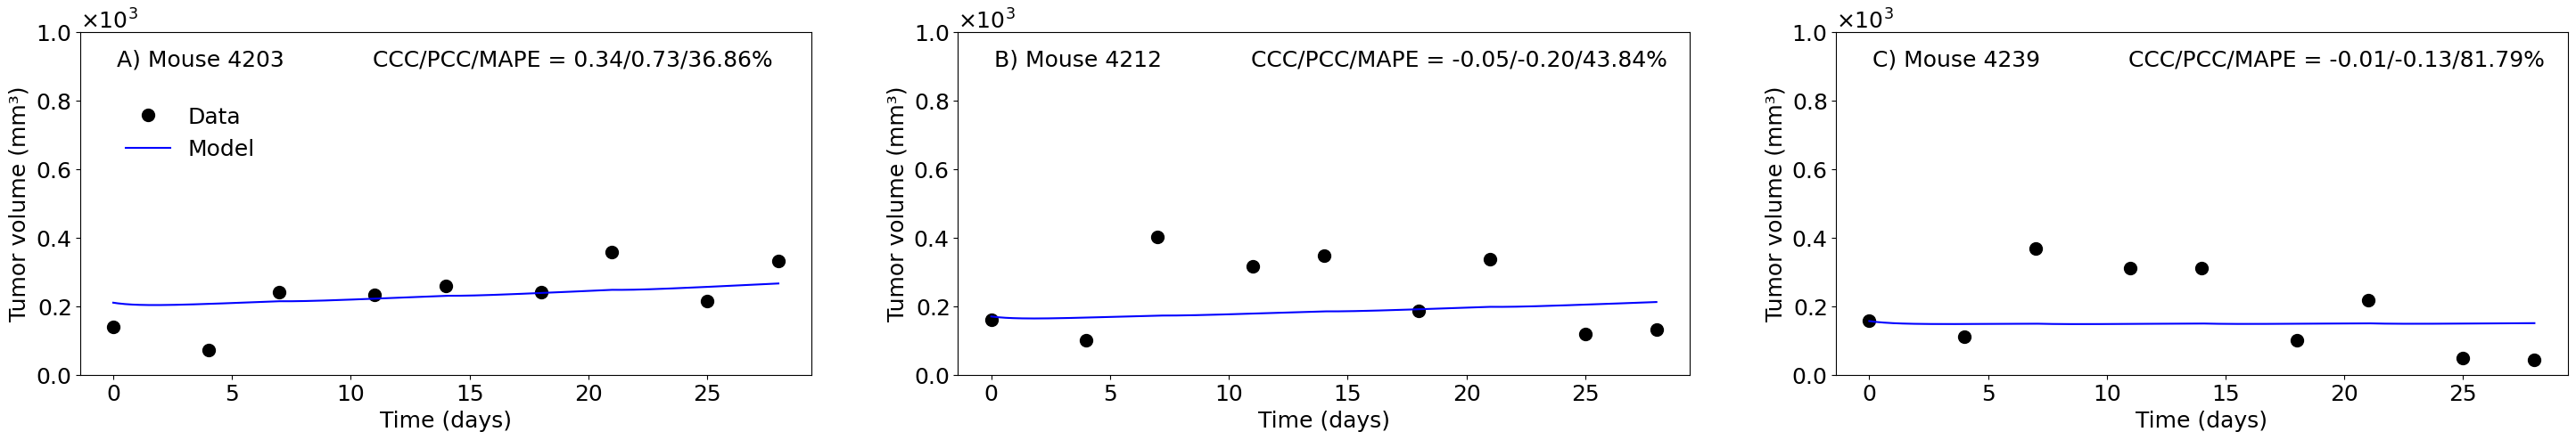

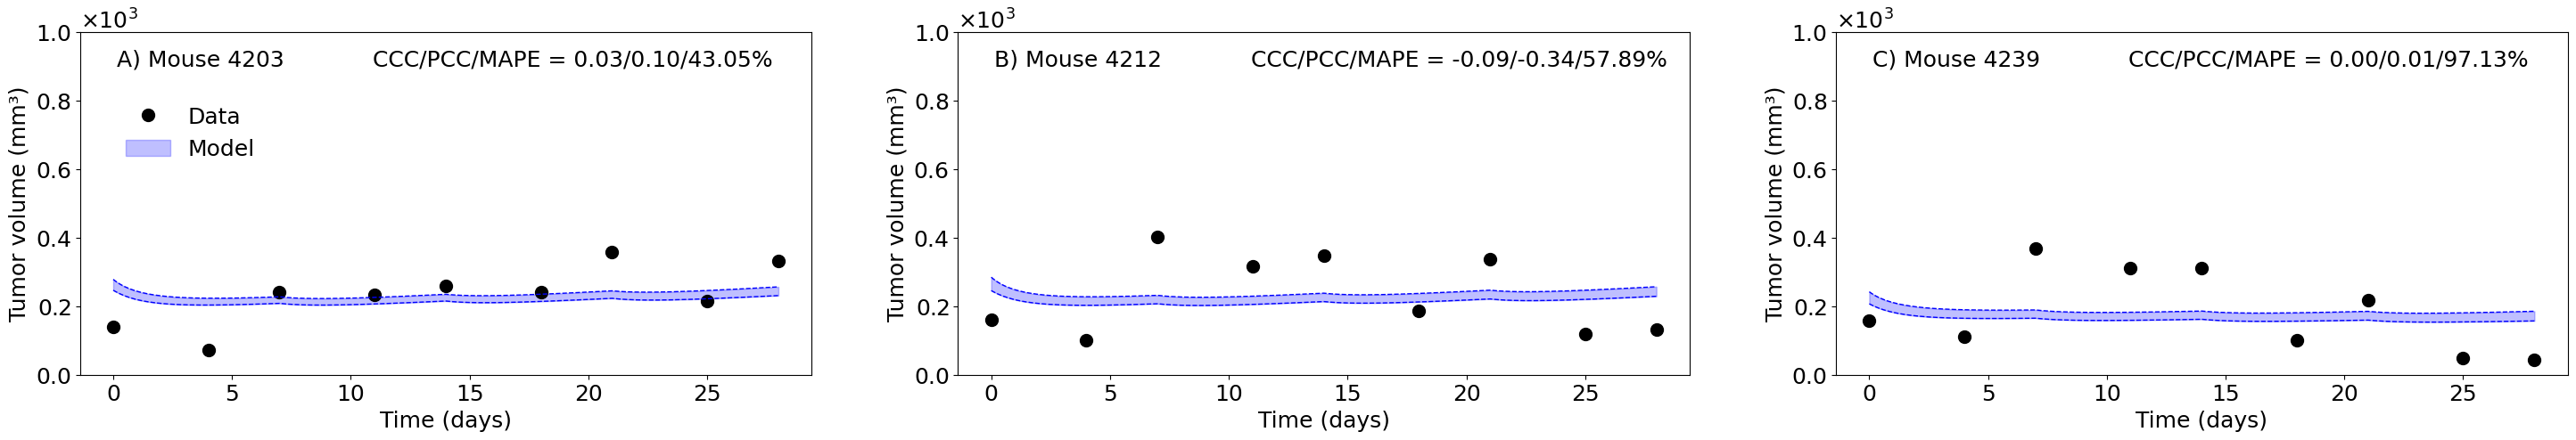

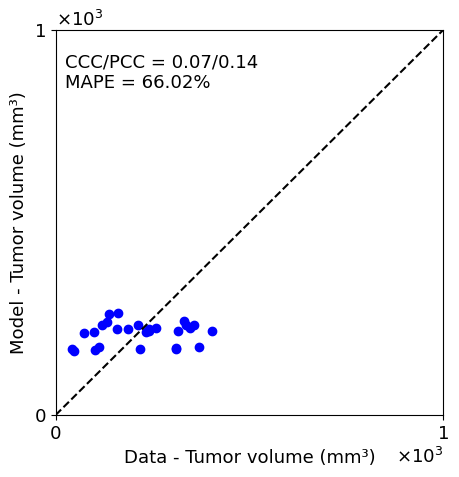

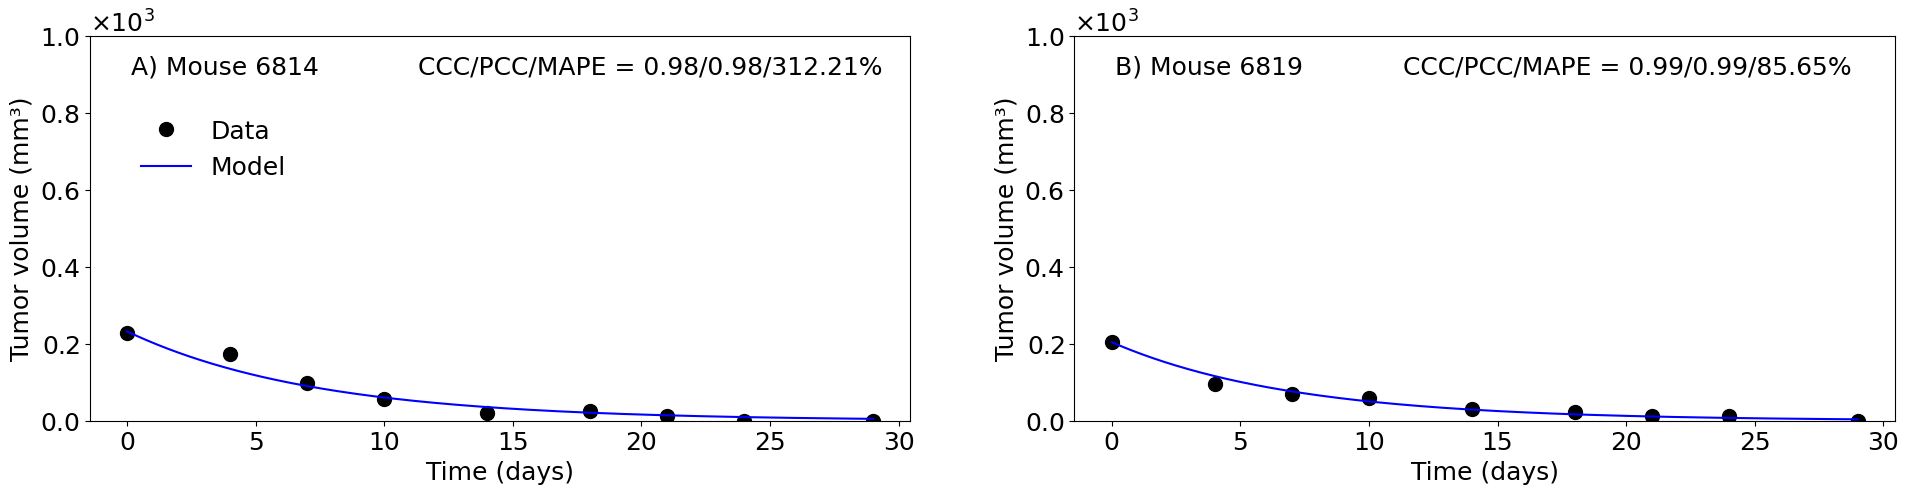

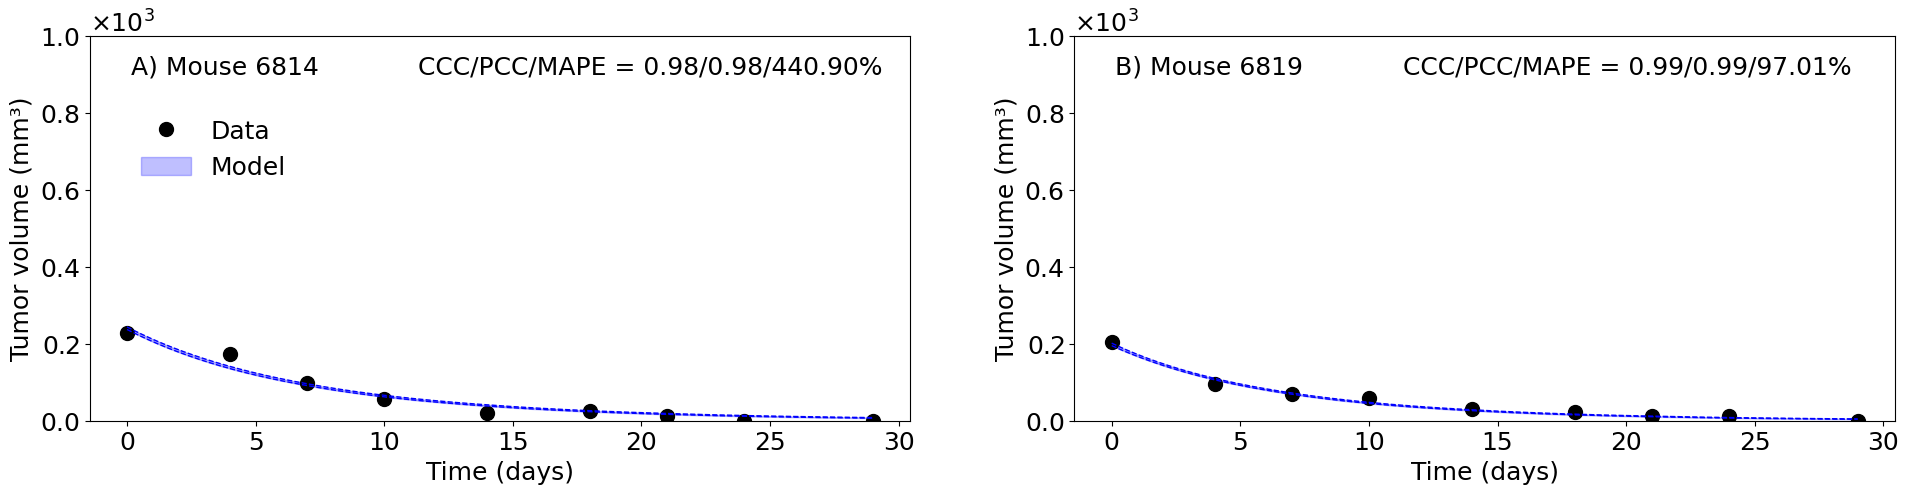

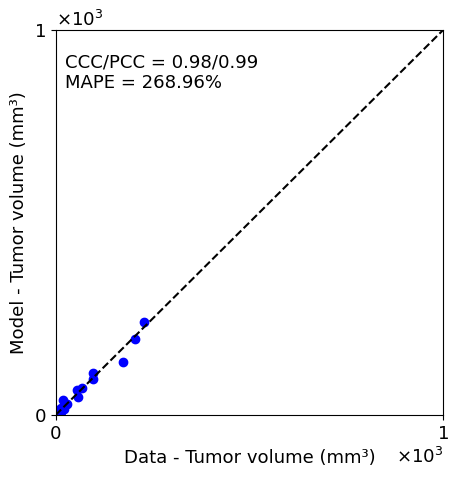

In [4]:
show_f = True
save_f = False
plot_figures = True

# Run MCMC with NUTS
all_models = ['_exp_sas']
all_treat = ['Pac+Carbo-4wk']
full_data = fp.read_data(files_location,verbose = True,number_of_data = 9,filter = True, biomarkers = True)
for treat in all_treat:
    for group in full_data:
        for model_extension in all_models:
            # Load the MCMC object
            output_name = f'{model_extension}_{group}_{treat}'
            
            with open(f'{file_location}mcmc{output_name}.pkl', 'rb') as f:
                mcmc = pickle.load(f)
            
            # Load `my_samples` and `predictive_samples`
            with open(f'{file_location}chain{output_name}.pkl', "rb") as f:
                samples = pickle.load(f)
            
            with open(f'{file_location}prediction{output_name}.pkl', "rb") as f:
                predictive_samples = pickle.load(f)
    
            # Load the .npz file
            bestfile = np.load(f'{file_location}multiple_ll_pars{output_name}.npz')
            
            # Access the variables
            max_ll = bestfile['max_ll']
            best_pars = bestfile['best_pars']
            min_index = bestfile['min_index']
            labels = bestfile['labels']
            bic_results = bestfile['bic_results']
            waic = bestfile['waic']
    
            if plot_figures:
                # fig = corner.corner(samples, labels = labels, truths = best_pars)
                # plt.savefig(f'{file_location}corner{output_name}.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.02)
                # if show_f:
                #     plt.show()
                # else:
                #     plt.close()
                opt_name = f'{model_extension}_{group}_{treat}'
                fm = fp.plot_maxll_avg(predictive_samples, full_data, group, treat, model_extension = model_extension, labels = labels, samples = samples, nCols = 3, min_index = min_index, show = show_f, save = save_f, figure_name = f'{file_location}max_ll{opt_name}.pdf')
                fa = fp.plot_maxll_avg(predictive_samples, full_data, group, treat, model_extension = model_extension, labels = labels, samples = samples, nCols = 3, show = show_f, save = save_f, figure_name = f'{file_location}avg{opt_name}.pdf')
                with open(f'{file_location}model_4weeks{output_name}.pkl', "wb") as f:
                    pickle.dump(fm[0], f)
                # fp.plot_scatter(fm[1], fm[0], save = save_f, show = show_f, figure_name = f'{file_location}scatter_plot_max_ll{opt_name}.pdf')
                fp.plot_scatter(fa[1], fa[0], save = save_f, show = show_f, figure_name = f'{file_location}scatter_plot_avg{opt_name}.pdf')
                # fp.plot_scatter_color(fm[1], fm[0], save = save_f, show = show_f, figure_name = f'{file_location}scatter_plot_max_ll_color{opt_name}.pdf')
                # fp.plot_scatter_color(fa[1], fa[0], save = save_f, show = show_f, figure_name = f'{file_location}scatter_plot_avg_color{opt_name}.pdf')
                # fp.plot_chain(samples, labels, figure_name = f'{file_location}chain{output_name}.pdf', save = save_f, show = show_f, nCols = 4)
                # fp.plot_chain_box_plot(samples, labels, save = save_f, show = show_f, nCols = 4, figure_name = f'{file_location}chain_box_plot{output_name}.pdf')

In [5]:
calibrate = False
if calibrate:
    # Run MCMC with NUTS
    #all_models = ['_bert','_exp','_gomp','_lin','_log','_mendel','_surf']
    all_models = ['_exp_sas']
    for number_of_data in range(2,9):
        print(f'\n\n\n                                 KATIA {number_of_data}         \n\n\n\n')
        full_data = fp.read_data(files_location,verbose = False,number_of_data = number_of_data,filter = True, biomarkers = True)
        for model_extension in all_models:
            #all_treat = ['G01-Untreated', 'G05-Pac+Carbo-1wk', 'G06-Pac+Carbo-4wk']
            all_treat = ['Pac+Carbo-4wk']
            for treat in all_treat:
                for group in full_data:
                    rng_key = random.PRNGKey(0)
                    
                    kernel = NUTS(tumor_model_jax, target_accept_prob=0.9)
                    mcmc = MCMC(kernel, num_warmup=3000, num_samples=6000, num_chains=1)
                    mcmc.run(rng_key, full_data = full_data, model_extension = model_extension, group = group, treat = treat)
                    mcmc.print_summary()
            
                    # Save the MCMC object
                    output_name = f'{model_extension}-{number_of_data}_{group}_{treat}'
                    with open(f'{file_location}mcmc{output_name}.pkl', 'wb') as f:
                        pickle.dump(mcmc, f)
                    
                    samples = mcmc.get_samples()
                    predictive_samples = samples[f'y_model_{group}_{treat}']
                    samples.pop(f'y_model_{group}_{treat}',None)
                    
                    # Save `my_samples` and `predictive_samples` to a file
                    with open(f'{file_location}chain{output_name}.pkl', "wb") as f:
                        pickle.dump(samples, f)
                    
                    with open(f'{file_location}prediction{output_name}.pkl', "wb") as f:
                        pickle.dump(predictive_samples, f)
                
                    labels = [l for l in samples.keys()]
                    min_index, best_pars, max_ll = fp.get_best_pars_maxll(predictive_samples, full_data, group, treat, samples)
            
                    k = len(labels)-np.sum(['ic' in x for x in labels])
                    n = 0
                    for mouse in full_data[group][treat]:
                        n += len(full_data[group][treat][mouse][:,0])
                    bic_results = k*np.log(n)-2*max_ll
            
                    # Compute log-likelihood for each data point
                    ll = log_likelihood(tumor_model_jax, samples, full_data=full_data, model_extension=model_extension, group=group, treat=treat)
                    
                    # Ensure correct site name for observation
                    obs_site_name = f'obs_{list(full_data[group][treat].keys())[0]}'  # First key should correspond to an observation
                    if obs_site_name not in ll:
                        raise KeyError(f"Observation site '{obs_site_name}' not found in log-likelihood results. Available keys: {ll.keys()}")
                    
                    # Compute WAIC
                    lppd = np.sum(np.log(np.mean(np.exp(ll[obs_site_name]), axis=0)))  # Log pointwise predictive density
                    p_waic = np.sum(np.var(ll[obs_site_name], axis=0))  # Effective number of parameters
                    waic = -2 * (lppd - p_waic)
            
                    np.savez(f'{file_location}multiple_ll_pars{output_name}.npz', max_ll = max_ll, best_pars = best_pars, min_index = min_index, labels = labels, bic_results = bic_results, waic = waic, lppd = lppd, p_waic = p_waic)

In [6]:
show_f = False
save_f = True
plot_figures = True

full_data = fp.read_data(files_location,verbose = True,number_of_data = 9,filter = True, biomarkers = True)

# Run MCMC with NUTS
all_models = ['_exp_sas']
all_treat = ['Pac+Carbo-4wk']
for number_of_data in range(2,9):
    print(f'Number of Data = {number_of_data}')
    for treat in all_treat:
        for group in full_data:
            for model_extension in all_models:
                # Load the MCMC object
                output_name = f'{model_extension}-{number_of_data}_{group}_{treat}'
                
                with open(f'{file_location}mcmc{output_name}.pkl', 'rb') as f:
                    mcmc = pickle.load(f)
                
                # Load `my_samples` and `predictive_samples`
                with open(f'{file_location}chain{output_name}.pkl', "rb") as f:
                    samples = pickle.load(f)
                
                with open(f'{file_location}prediction{output_name}.pkl', "rb") as f:
                    predictive_samples = pickle.load(f)
        
                # Load the .npz file
                bestfile = np.load(f'{file_location}multiple_ll_pars{output_name}.npz')
                
                # Access the variables
                max_ll = bestfile['max_ll']
                best_pars = bestfile['best_pars']
                min_index = bestfile['min_index']
                labels = bestfile['labels']
                bic_results = bestfile['bic_results']
                waic = bestfile['waic']
        
                if plot_figures:
                    # fig = corner.corner(samples, labels = labels, truths = best_pars)
                    # plt.savefig(f'{file_location}corner{output_name}.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.02)
                    # if show_f:
                    #     plt.show()
                    # else:
                    #     plt.close()
                    opt_name = f'{model_extension}-{number_of_data}_{group}_{treat}'
                    fm = fp.plot_maxll_avg(predictive_samples, full_data, group, treat, number_of_data = number_of_data, model_extension = model_extension, labels = labels, samples = samples, nCols = 3, min_index = min_index, show = show_f, save = save_f, figure_name = f'{file_location}max_ll{opt_name}.pdf')
                    fa = fp.plot_maxll_avg(predictive_samples, full_data, group, treat, number_of_data = number_of_data, model_extension = model_extension, labels = labels, samples = samples, nCols = 3, show = show_f, save = save_f, figure_name = f'{file_location}avg{opt_name}.pdf')
                    with open(f'{file_location}model_points{output_name}.pkl', "wb") as f:
                        pickle.dump(fm[0], f)
                    # fp.plot_scatter(fm[1], fm[0], number_of_data = number_of_data, save = save_f, show = show_f, figure_name = f'{file_location}scatter_plot_max_ll{opt_name}.pdf')
                    fp.plot_scatter(fa[1], fa[0], number_of_data = number_of_data, save = save_f, show = show_f, figure_name = f'{file_location}scatter_plot_avg{opt_name}.pdf')
                    # fp.plot_scatter_color(fm[1], fm[0], number_of_data = number_of_data, save = save_f, show = show_f, figure_name = f'{file_location}scatter_plot_max_ll_color{opt_name}.pdf')
                    # fp.plot_scatter_color(fa[1], fa[0], number_of_data = number_of_data, save = save_f, show = show_f, figure_name = f'{file_location}scatter_plot_avg_color{opt_name}.pdf')
                    # fp.plot_chain(samples, labels, figure_name = f'{file_location}chain{output_name}.pdf', save = save_f, show = show_f, nCols = 4)
                    # fp.plot_chain_box_plot(samples, labels, save = save_f, show = show_f, nCols = 4, figure_name = f'{file_location}chain_box_plot{output_name}.pdf')

Scenario: 15120-TG7, Untreated, 4423, 4435, 4437, 4440, 4447, 4468, Pac+Carbo-4wk, 4430, 4431, biomarkers, 4430, 4431
Scenario: 2277-R1TG9, Untreated, 4809, 4813, 4815, 4822, 4826, 4839, Pac+Carbo-4wk, 4811, 4814, 4834, biomarkers, 4811, 4814, 4834
Scenario: 3204-R3TG5, Untreated, 4691, 4702, 4714, Pac+Carbo-4wk, 4678, 4686, 4705, biomarkers, 4678, 4686, 4705
Scenario: 4849-R1TG15, Untreated, 4301, 4315, 4332, 4362, 4364, 4373, Pac+Carbo-4wk, 4304, 4331, 4354, biomarkers, 4304, 4331, 4354
Scenario: BCM-3204, Untreated, 11, 15, 8, Pac+Carbo-4wk, 13, 28, biomarkers, 13, 28
Scenario: BMC-4175, Untreated, 6702, 6704, 6712, Pac+Carbo-4wk, 6720, 6723, biomarkers, 6720, 6723
Scenario: BRA45-R2TG8-Repeat, Untreated, 4504, 4506, 4507, 4515, Pac+Carbo-4wk, 4541, biomarkers, 4541
Scenario: HCI-034-TG11-Repeat, Untreated, 4215, 4224, 4229, 4233, 4235, 4240, Pac+Carbo-4wk, 4203, 4212, 4239, biomarkers, 4203, 4212, 4239
Scenario: MDA-BCM-IBC-103, Untreated, 6809, 6829, 6835, Pac+Carbo-4wk, 6814, 681

In [7]:
def generate_table(full_data, model_extension):
    print(f'')
    print(r'\begin{table}[!htbp]')
    print(r'\resizebox{\textwidth}{!}{\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}')
    print(r'\hline')
    print(r'\multirow{2}{*}{} & \multicolumn{9}{c|}{Responders (R) / Non-responders (NR)} \\ \cline{2-10}')
    print(r' & Data & 4 weeks & 2 points & 3 points & 4 points & 5 points & 6 points & 7 points & 8 points \\ \hline')
    for group in full_data:
        print(group, end = ' ')
        for treat in full_data[group]:
            if '4wk' not in treat:
                continue
                
            R = NR = 0
            for mouse in full_data[group][treat]:
                if full_data[group][treat][mouse][:,1][-1] < full_data[group][treat][mouse][:,1][0]:
                    R += 1
                else:
                    NR +=1
            if R > NR:
                print(r'& \cellcolor{green!30}', end = ' ')
            else:
                print(r'& \cellcolor{red!30}', end = ' ')
            print(f'R({R})/NR({NR})',end = ' ')

            R = NR = 0
            search_key = f'./Output/*model_4weeks*{model_extension}*{group}*.pkl'
            file_key = sorted(glob.glob(search_key))[0]
            with open(file_key, "rb") as f:
                model_outputs = pickle.load(f)
            print(f'\n\n{len(model_outputs)}')
            print(model_outputs)
            print(file_key)
            break
            for mouse in model_outputs:
                if mouse[-1] < mouse[0]:
                    R += 1
                else:
                    NR +=1
            if R > NR:
                print(r'& \cellcolor{green!30}', end = ' ')
            else:
                print(r'& \cellcolor{red!30}', end = ' ')
            print(f'R({R})/NR({NR})',end = ' ')

#             R = NR = 0
#             search_key = f'./Output/*model_2weeks*{group}*.pkl'
#             file_key = sorted(glob.glob(search_key))[0]
#             with open(file_key, "rb") as f:
#                 model_outputs = pickle.load(f)
#             for mouse in model_outputs:
#                 if mouse[-1] < mouse[0]:
#                     R += 1
#                 else:
#                     NR +=1
#             if R > NR:
#                 print(r'& \cellcolor{green!30}', end = ' ')
#             else:
#                 print(r'& \cellcolor{red!30}', end = ' ')
#             print(f'R({R})/NR({NR})',end = ' ')

            
            search_key = f'./Output/*model_points*{model_extension}*{group}*.pkl'
            f_keys = sorted(glob.glob(search_key))
            for file_key in f_keys:
                R = NR = 0
                with open(file_key, "rb") as f:
                    model_outputs = pickle.load(f)
                for mouse in model_outputs:
                    if mouse[-1] < mouse[0]:
                        R += 1
                    else:
                        NR +=1
                if R > NR:
                    print(r'& \cellcolor{green!30}', end = ' ')
                else:
                    print(r'& \cellcolor{red!30}', end = ' ')
                print(f'R({R})/NR({NR})',end = ' ')

        print(r'\\ \hline')
        break
    print(r'\end{tabular}}')
    print(r'\end{table}')
    return

generate_table(full_data, model_extension = '_exp_sas')


\begin{table}[!htbp]
\resizebox{\textwidth}{!}{\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
\multirow{2}{*}{} & \multicolumn{9}{c|}{Responders (R) / Non-responders (NR)} \\ \cline{2-10}
 & Data & 4 weeks & 2 points & 3 points & 4 points & 5 points & 6 points & 7 points & 8 points \\ \hline
15120-TG7 & \cellcolor{green!30} R(2)/NR(0) 

2
[Array([327.79242 , 198.33908 , 136.40837 ,  82.946304,  57.257404,
        34.93034 ,  24.170855,  14.769396,   9.058243], dtype=float32), Array([228.73569 , 138.07806 ,  94.79674 ,  57.508358,  39.627926,
        24.118677,  16.660147,  10.15617 ,   6.214311], dtype=float32)]
./Output/model_4weeks_exp_sas_15120-TG7_Pac+Carbo-4wk.pkl
\\ \hline
\end{tabular}}
\end{table}


In [8]:
def generate_table(full_data, model_extension, just_color = False):
    print(f'')
    print(r'\begin{table}[!htbp]')
    print(r'\resizebox{\textwidth}{!}{\begin{tabular}{|c||c||c|c|c|c|c|c|c|c|}')
    print(r'\hline')
    print(r'\multirow{2}{*}{} & \multicolumn{9}{c|}{\textbf{Days used for calibration}} \\ \cline{2-10}')
    print(r' & Data & 4 days & 7 days & 11 days & 14 days & 18 days & 21 days & 25 days & 28 days\\ \hline')
    for group in full_data:
        print(group, end = ' ')
        for treat in full_data[group]:
            if '4wk' not in treat:
                continue
                
            R = NR = 0
            for mouse in full_data[group][treat]:
                if full_data[group][treat][mouse][:,1][-1] < full_data[group][treat][mouse][:,1][0]:
                    R += 1
                else:
                    NR +=1
            if R >= NR:
                print(r'& Responders', end = ' ')
            else:
                print(r'& Non-responders', end = ' ')
            if not just_color:
                print(f'R({R})/NR({NR})',end = ' ')


            
            search_key = f'./Output/*model_points*{model_extension}*{group}*.pkl'
            f_keys = sorted(glob.glob(search_key))
            for file_key in f_keys:
                R = NR = 0
                with open(file_key, "rb") as f:
                    model_outputs = pickle.load(f)
                for mouse in model_outputs:
                    if mouse[-1] < mouse[0]:
                        R += 1
                    else:
                        NR +=1
                if R >= NR:
                    print(r'& \cellcolor{green!30}', end = ' ')
                else:
                    print(r'& \cellcolor{red!30}', end = ' ')
                if not just_color:
                    print(f'R({R})/NR({NR})',end = ' ')

            R = NR = 0
            search_key = f'./Output/*model_4weeks*{model_extension}*{group}*.pkl'
            file_key = sorted(glob.glob(search_key))[0]
            with open(file_key, "rb") as f:
                model_outputs = pickle.load(f)
            # print(f'\n\n{len(model_outputs)}')
            # print(model_outputs)
            # print(file_key)
            # break
            for mouse in model_outputs:
                if mouse[-1] < mouse[0]:
                    R += 1
                else:
                    NR +=1
            if R >= NR:
                print(r'& \cellcolor{green!30}', end = ' ')
            else:
                print(r'& \cellcolor{red!30}', end = ' ')
            if not just_color:
                print(f'R({R})/NR({NR})',end = ' ')

        print(r'\\ \hline')
        #break
    print(r'\end{tabular}}')
    print(r'\end{table}')
    return
    
full_data = fp.read_data(files_location,verbose = True,number_of_data = 9,filter = True, biomarkers = True)
generate_table(full_data, model_extension = '_exp_treat', just_color = False)

Scenario: 15120-TG7, Untreated, 4423, 4435, 4437, 4440, 4447, 4468, Pac+Carbo-4wk, 4430, 4431, biomarkers, 4430, 4431
Scenario: 2277-R1TG9, Untreated, 4809, 4813, 4815, 4822, 4826, 4839, Pac+Carbo-4wk, 4811, 4814, 4834, biomarkers, 4811, 4814, 4834
Scenario: 3204-R3TG5, Untreated, 4691, 4702, 4714, Pac+Carbo-4wk, 4678, 4686, 4705, biomarkers, 4678, 4686, 4705
Scenario: 4849-R1TG15, Untreated, 4301, 4315, 4332, 4362, 4364, 4373, Pac+Carbo-4wk, 4304, 4331, 4354, biomarkers, 4304, 4331, 4354
Scenario: BCM-3204, Untreated, 11, 15, 8, Pac+Carbo-4wk, 13, 28, biomarkers, 13, 28
Scenario: BMC-4175, Untreated, 6702, 6704, 6712, Pac+Carbo-4wk, 6720, 6723, biomarkers, 6720, 6723
Scenario: BRA45-R2TG8-Repeat, Untreated, 4504, 4506, 4507, 4515, Pac+Carbo-4wk, 4541, biomarkers, 4541
Scenario: HCI-034-TG11-Repeat, Untreated, 4215, 4224, 4229, 4233, 4235, 4240, Pac+Carbo-4wk, 4203, 4212, 4239, biomarkers, 4203, 4212, 4239
Scenario: MDA-BCM-IBC-103, Untreated, 6809, 6829, 6835, Pac+Carbo-4wk, 6814, 681

In [9]:
def generate_recist_table(full_data, model_extension):
    print(f'')
    print(r'\begin{table}[!htbp]')
    print(r'\resizebox{\textwidth}{!}{\begin{tabular}{|c||c||c|c|c|c|c|c|c|c|}')
    print(r'\hline')
    print(r'\multirow{2}{*}{} & \multicolumn{9}{c|}{\textbf{\color{green!50!black}Responders (R)} / \textbf{\color{blue}Stable disease (SD)}/ \textbf{\color{red}Progressive disease (PD)}} \\ \cline{2-10}')
    print(r' & Data & 4 weeks & 4 days & 7 days & 11 days & 14 days & 18 days & 21 days & 25 days \\ \hline')
    for group in full_data:
        # if group not in '2277-R1TG9':
        #     continue
        text_to_print = ''
        
        # Color map for LaTeX highlighting
        colors = {
            'R': r'\cellcolor{green!30}',
            'PD': r'\cellcolor{red!30}',
            'SD': r'\cellcolor{blue!20}',
        }
            
        text_to_print += f'{group} '
        
        for treat in full_data[group]:
            if '4wk' not in treat:
                continue
                
            R = PD = SD = 0
            mice_response = []
            for mouse in full_data[group][treat]:
                if full_data[group][treat][mouse][:,1][-1]/full_data[group][treat][mouse][:,1][0] < 0.7:
                    R += 1
                    mice_response.append('R')
                elif full_data[group][treat][mouse][:,1][-1]/full_data[group][treat][mouse][:,1][0] > 1.2:
                    PD += 1
                    mice_response.append('PD')
                else:
                    SD += 1
                    mice_response.append('SD')
            # Store in a dictionary
            responses = {'R': R, 'SD': SD, 'PD': PD}
            # print(f'mice_response: {mice_response}')
            # print(f'responses: {responses}')
            max_val = max(responses.values())

            # Print with appropriate color for the largest one
            # for key in ['CR', 'PR', 'SD', 'PD']:
            #     if responses[key] == max_val and max_val > 0:
            #         print(f"& {colors[key]}", end=' ')
                    
            print_text = ''
            for key in ['R', 'SD', 'PD']:
                if responses[key]:
                    if print_text != '':
                        print_text += f'/{key}({responses[key]})'
                    else:
                        print_text += f'& {key}({responses[key]})'
            
            text_to_print += f'{print_text} '
            
            CP = WP = 0
            responses = {'R': 0, 'SD': 0, 'PD': 0}
            search_key = f'./Output/*model_4weeks*{model_extension}*{group}*.pkl'
            file_key = sorted(glob.glob(search_key))[0]
            with open(file_key, "rb") as f:
                model_outputs = pickle.load(f)

            # print()
            for n, mouse in enumerate(model_outputs):
                if mouse[-1]/mouse[0] < 0.7:
                    status = 'R'
                elif mouse[-1]/mouse[0] > 1.2:
                    status = 'PD'
                else:
                    status = 'SD'
                # print(f'{n}, {status}, {mice_response[n]}')
                if status == mice_response[n]:
                    CP += 1
                else:
                    WP += 1
                responses[status] += 1
            if CP > WP:
                text_to_print += r'& \cellcolor{green!30} '
            elif CP == WP:
                text_to_print += r'& \cellcolor{yellow!30} '
            else:
                text_to_print += r'& \cellcolor{red!30} '
            print_text = ''
            for key in ['R', 'SD', 'PD']:
                if responses[key]:
                    if print_text != '':
                        print_text += f'/{key}({responses[key]})'
                    else:
                        print_text += f'{key}({responses[key]})'
            
            text_to_print += f'{print_text} '
            # print()
            #print(f'CP({CP})/WP({WP})',end = ' ')

            search_key = f'./Output/*model_points*{model_extension}*{group}*.pkl'
            f_keys = sorted(glob.glob(search_key))
            for file_key in f_keys:
                CP = WP = 0
                responses = {'R': 0, 'SD': 0, 'PD': 0}
                with open(file_key, "rb") as f:
                    model_outputs = pickle.load(f)
                for n,mouse in enumerate(model_outputs):
                    if mouse[-1]/mouse[0] < 0.7:
                        status = 'R'
                    elif mouse[-1]/mouse[0] > 1.2:
                        status = 'PD'
                    else:
                        status = 'SD'
                    if status == mice_response[n]:
                        CP += 1
                    else:
                        WP += 1
                    responses[status] += 1
                if CP > WP:
                    text_to_print += r'& \cellcolor{green!30} '
                elif CP == WP:
                    text_to_print += r'& \cellcolor{yellow!30} '
                else:
                    text_to_print += r'& \cellcolor{red!30} '
                print_text = ''
                for key in ['R', 'SD', 'PD']:
                    if responses[key]:
                        if print_text != '':
                            print_text += f'/{key}({responses[key]})'
                        else:
                            print_text += f'{key}({responses[key]})'

                text_to_print += f'{print_text} '
                #print(f'CP({CP})/WP({WP})',end = ' ')
                #     if mouse[-1] < mouse[0]:
                #         R += 1
                #     else:
                #         NR +=1
                # if R > NR:
                #     print(r'& \cellcolor{green!30}', end = ' ')
                # else:
                #     print(r'& \cellcolor{red!30}', end = ' ')
                # print(f'R({R})/NR({NR})',end = ' ')

        text_to_print += r'\\ \hline'
        print(text_to_print)
        #break
    print(r'\end{tabular}}')
    print(r'\end{table}')
    return

full_data = fp.read_data(files_location,verbose = True,number_of_data = 9,filter = True, biomarkers = True)
generate_recist_table(full_data, model_extension = '_exp_treat')

Scenario: 15120-TG7, Untreated, 4423, 4435, 4437, 4440, 4447, 4468, Pac+Carbo-4wk, 4430, 4431, biomarkers, 4430, 4431
Scenario: 2277-R1TG9, Untreated, 4809, 4813, 4815, 4822, 4826, 4839, Pac+Carbo-4wk, 4811, 4814, 4834, biomarkers, 4811, 4814, 4834
Scenario: 3204-R3TG5, Untreated, 4691, 4702, 4714, Pac+Carbo-4wk, 4678, 4686, 4705, biomarkers, 4678, 4686, 4705
Scenario: 4849-R1TG15, Untreated, 4301, 4315, 4332, 4362, 4364, 4373, Pac+Carbo-4wk, 4304, 4331, 4354, biomarkers, 4304, 4331, 4354
Scenario: BCM-3204, Untreated, 11, 15, 8, Pac+Carbo-4wk, 13, 28, biomarkers, 13, 28
Scenario: BMC-4175, Untreated, 6702, 6704, 6712, Pac+Carbo-4wk, 6720, 6723, biomarkers, 6720, 6723
Scenario: BRA45-R2TG8-Repeat, Untreated, 4504, 4506, 4507, 4515, Pac+Carbo-4wk, 4541, biomarkers, 4541
Scenario: HCI-034-TG11-Repeat, Untreated, 4215, 4224, 4229, 4233, 4235, 4240, Pac+Carbo-4wk, 4203, 4212, 4239, biomarkers, 4203, 4212, 4239
Scenario: MDA-BCM-IBC-103, Untreated, 6809, 6829, 6835, Pac+Carbo-4wk, 6814, 681

In [10]:
def generate_color_table(full_data, model_extension):
    print(f'')
    print(r'\begin{table}[!htbp]')
    print(r'\resizebox{\textwidth}{!}{\begin{tabular}{|c||c||c|c|c|c|c|c|c|c|}')
    print(r'\hline')
    print(r'\multirow{2}{*}{} & \multicolumn{9}{c|}{\textbf{Days used for calibration}} \\ \cline{2-10}')
    print(r' & Data & 4 days & 7 days & 11 days & 14 days & 18 days & 21 days & 25 days & 28 days\\ \hline')
    for group in full_data:
        text_to_print = ''
        text_to_print += f'{group} '
        
        for treat in full_data[group]:
            if '4wk' not in treat:
                continue
                
            R = NR = 0
            mice_response = []
            for mouse in full_data[group][treat]:
                if full_data[group][treat][mouse][:,1][-1] < full_data[group][treat][mouse][:,1][0]:
                    R += 1
                    mice_response.append('R')
                else:
                    NR += 1
                    mice_response.append('NR')
            if R >= NR:
                text_to_print += r'& Responders '
            else:
                text_to_print += r'& Non-responders '
                       
            search_key = f'./Output/*model_points*{model_extension}*{group}*.pkl'
            f_keys = sorted(glob.glob(search_key))
            for file_key in f_keys:
                CP = WP = 0
                with open(file_key, "rb") as f:
                    model_outputs = pickle.load(f)
                for n,mouse in enumerate(model_outputs):
                    if mouse[-1] < mouse[0]:
                        status = 'R'
                    else:
                        status = 'NR'
                    if status == mice_response[n]:
                        CP += 1
                    else:
                        WP += 1
                if CP > WP:
                    text_to_print += r'& \cellcolor{green!30} '
                elif CP == WP:
                    text_to_print += r'& \cellcolor{green!30} '
                else:
                    text_to_print += r'& \cellcolor{red!30} '

            CP = WP = 0
            search_key = f'./Output/*model_4weeks*{model_extension}*{group}*.pkl'
            file_key = sorted(glob.glob(search_key))[0]
            with open(file_key, "rb") as f:
                model_outputs = pickle.load(f)
            for n, mouse in enumerate(model_outputs):
                if mouse[-1] < mouse[0]:
                    status = 'R'
                else:
                    status = 'NR'
                if status == mice_response[n]:
                    CP += 1
                else:
                    WP += 1
            if CP > WP:
                text_to_print += r'& \cellcolor{green!30} '
            elif CP == WP:
                text_to_print += r'& \cellcolor{green!30} '
            else:
                text_to_print += r'& \cellcolor{red!30} '

        text_to_print += r'\\ \hline'
        print(text_to_print)
        #break
    print(r'\end{tabular}}')
    print(r'\end{table}')
    return

full_data = fp.read_data(files_location,verbose = True,number_of_data = 9,filter = True, biomarkers = True)
generate_color_table(full_data, model_extension = '_exp_bio')

Scenario: 15120-TG7, Untreated, 4423, 4435, 4437, 4440, 4447, 4468, Pac+Carbo-4wk, 4430, 4431, biomarkers, 4430, 4431
Scenario: 2277-R1TG9, Untreated, 4809, 4813, 4815, 4822, 4826, 4839, Pac+Carbo-4wk, 4811, 4814, 4834, biomarkers, 4811, 4814, 4834
Scenario: 3204-R3TG5, Untreated, 4691, 4702, 4714, Pac+Carbo-4wk, 4678, 4686, 4705, biomarkers, 4678, 4686, 4705
Scenario: 4849-R1TG15, Untreated, 4301, 4315, 4332, 4362, 4364, 4373, Pac+Carbo-4wk, 4304, 4331, 4354, biomarkers, 4304, 4331, 4354
Scenario: BCM-3204, Untreated, 11, 15, 8, Pac+Carbo-4wk, 13, 28, biomarkers, 13, 28
Scenario: BMC-4175, Untreated, 6702, 6704, 6712, Pac+Carbo-4wk, 6720, 6723, biomarkers, 6720, 6723
Scenario: BRA45-R2TG8-Repeat, Untreated, 4504, 4506, 4507, 4515, Pac+Carbo-4wk, 4541, biomarkers, 4541
Scenario: HCI-034-TG11-Repeat, Untreated, 4215, 4224, 4229, 4233, 4235, 4240, Pac+Carbo-4wk, 4203, 4212, 4239, biomarkers, 4203, 4212, 4239
Scenario: MDA-BCM-IBC-103, Untreated, 6809, 6829, 6835, Pac+Carbo-4wk, 6814, 681